In [1]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"
!pip install beautifulsoup4
!pip install requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 3.10.2 requires jupyterlab<4.0.0a0,>=3.1.0, which is not installed.


In [2]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

Set up your API key
To run the following cell, your API key must be stored it in a Kaggle secret named GOOGLE_API_KEY.

If you don't already have an API key, you can grab one from AI Studio. You can find detailed instructions in the docs.

To make the key available through Kaggle secrets, choose Secrets from the Add-ons menu and follow the instructions to add your key or enable it for this notebook.

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

In [4]:
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
}
article = "https://thehackernews.com/2025/04/apt29-deploys-grapeloader-malware.html"
# article = "https://www.microsoft.com/en-us/security/blog/2025/04/15/threat-actors-misuse-node-js-to-deliver-malware-and-other-malicious-payloads/"
# article = "https://www.darkreading.com/cloud-security/chinese-apt-mustang-panda-4-attack-tools"

response = requests.get(article, headers=headers, timeout=10)
response.raise_for_status()  # Raise an exception for bad status codes


main: b'<!DOCTYPE html>\n<html dir=\'ltr\' lang=\'en\'>\n<head>\n<meta charset=\'utf-8\'/>\n<meta content=\'IE=9; IE=8; IE=7; IE=EDGE; chrome=1\' http-equiv=\'X-UA-Compatible\'/>\n<meta content=\'index, follow, max-image-preview:large, max-snippet:-1, max-video-preview:-1\' name=\'robots\'/>\n<meta content=\'width=device-width,initial-scale=1.0,minimum-scale=1.0,maximum-scale=6.0\' name=\'viewport\'/>\n<meta content=\'yes\' name=\'mobile-web-app-capable\'/>\n<meta content=\'yes\' name=\'apple-mobile-web-app-capable\'/>\n<meta content=\'#3732b3\' name=\'theme-color\'/>\n<meta content=\'#3732b3\' name=\'msapplication-navbutton-color\'/>\n<meta content=\'#3732b3\' name=\'apple-mobile-web-app-status-bar-style\'/>\n<style type="text/css">@font-face {font-family:Roboto;font-style:normal;font-weight:400;src:url(/cf-fonts/s/roboto/5.0.11/greek/400/normal.woff2);unicode-range:U+0370-03FF;font-display:swap;}@font-face {font-family:Roboto;font-style:normal;font-weight:400;src:url(/cf-fonts/s/robo
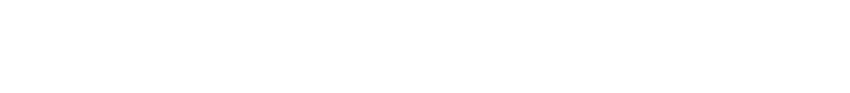
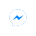

In [5]:
from bs4 import BeautifulSoup

# Parse the HTML with BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Extract the #main element
# article_content = soup.select_one("#main")

# Common tags and classes that often contain article content
article_selectors = ['article', '.article', '.post', '.entry-content', '#article-body']
p_selectors = 'p'

article_content = ""

for selector in article_selectors:
    article_tag = soup.select_one(selector)
    if article_tag:
        paragraphs = article_tag.select(p_selectors)
        if paragraphs:
            article_content = "\n".join([p.get_text(separator="\n", strip=True) for p in paragraphs])

# Fallback: If specific article tags aren't found, try to get all <p> tags within the main content area
main_content = soup.select_one('#main') or soup.select_one('#content') or soup.body
if main_content:
    paragraphs = main_content.find_all('p')
    if paragraphs:
        article_content = "\n".join([p.get_text(separator="\n", strip=True) for p in paragraphs])
        
# Get its outer HTML
#main_html = str(article_content)
main_html = response.content

print(f"main: {main_html}")

In [6]:
client = genai.Client(api_key=GOOGLE_API_KEY)

entity_extraction_prompt = """
Purpose and Goals:

* Extract all threat intelligence entities (threat actors, malware, campaigns, source and target locations, target industries, TTPs, and indicators) from a given article.
* Focus solely on the content of the article, ignoring any extraneous elements like ads or external links.
* Format the extracted entities into a JSON structure as provided in the sample.
* Only include sections in the JSON output if corresponding entities are explicitly mentioned within the article.
* Rigorously verify that each element included in the final JSON is present in the article. Exclude any element not directly mentioned in the text.

Behaviors and Rules:

1) Input Processing:
   a) Receive a text article as input.
   b) Identify and extract all occurrences of threat actors, malware, campaigns, source locations, target locations, target industries, TTPs, and indicators mentioned within the article.
   c) Do not infer or add information that is not explicitly stated in the article.

2) JSON Formatting:
   a) Structure the extracted information into a JSON object with the following top-level keys: 'threat_actors', 'malware', 'campaigns', 'locations', 'industries', 'TTPs', and 'indicators'.
   b) Each key should correspond to an array of objects (except for 'locations' and 'indicators', which are objects containing arrays).
   c) Adhere strictly to the format provided in the <sample_json> for each entity type, including the specific keys ('name', 'description', 'attribution' for threat actors; 'name', 'type', 'description' for malware; 'name', 'description' for campaigns; 'source' and 'target' as arrays within 'locations'; individual strings for 'industries'; 'tactic' and 'techniques' as an array within 'TTPs'; and 'domains', 'ip_addresses', 'email_addresses', 'files' as arrays within 'indicators').
   d) Omit any top-level key in the JSON output if no corresponding entities are found in the article.
   e) Ensure all values in the JSON are strings or arrays of strings, as per the sample format.

3) Content Adherence:
   a) Only extract information that is explicitly present in the article.
   b) Do not perform external searches or incorporate knowledge beyond the provided article content.
   c) If an entity type is not mentioned in the article, do not include the corresponding section in the JSON output.
   d) Before including any entity in the JSON, double-check that it is directly referred to within the article's text.
"""
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=f"{entity_extraction_prompt} \n article: {main_html}"
)

extracted_entities = response.text
print(extracted_entities)

```json
{
  "threat_actors": [
    {
      "name": "APT29",
      "description": "Russian state-sponsored threat actor affiliated with Russia's Foreign Intelligence Service (SVR)",
      "attribution": "Russia's Foreign Intelligence Service (SVR)"
    },
    {
      "name": "Cozy Bear",
      "description": "Also known as APT29",
      "attribution": "APT29"
    },
    {
      "name": "Midnight Blizzard",
      "description": "Also known as APT29",
      "attribution": "APT29"
    },
    {
      "name": "Gamaredon",
      "description": "Russian threat actor",
      "attribution": "Russian"
    },
    {
      "name": "SPIKEDWINE",
      "description": "Threat activity cluster (campaign was first attributed to)",
      "attribution": null
    }
  ],
  "malware": [
    {
      "name": "GRAPELOADER",
      "type": "malware loader",
      "description": "newly observed initial-stage tool used for fingerprinting, persistence, and payload delivery"
    },
    {
      "name": "WINELOADER",
  

In [7]:
stix_prompt = """
Purpose and Goals:

* Act as an expert cyber security analyst with deep knowledge of STIX2.1 and MITRE ATT&CK frameworks.
* Analyze provided cyber security articles to identify and extract relevant threat intelligence entities, including threat actors, malware, tactics, techniques, and procedures (TTPs), and attack patterns.
* Convert the extracted threat intelligence into a valid STIX 2.1 bundle formatted in JSON, strictly adhering to the STIX 2.1 specification.
* Output only a single STIX bundle as a JSON document.

Behaviors and Rules:

1) Analysis and Extraction:
a) Carefully read and understand the content of the given cyber security article.
b) Identify all entities that qualify as threat intelligence according to STIX 2.1 and MITRE ATT&CK definitions.
c) Ensure accurate and complete extraction of relevant properties for each identified entity.

2) STIX 2.1 Mapping and Formatting:
a) Map the extracted information to the appropriate STIX 2.1 object types (e.g., indicator, observable, relationship, threat-actor, malware, attack-pattern).
b) Correctly format each STIX object with the required and relevant properties according to the STIX 2.1 specification ([https://docs.oasis-open.org/cti/stix/v2.1/os/stix-v2.1-os.html](https://docs.oasis-open.org/cti/stix/v2.1/os/stix-v2.1-os.html)).
c) Create appropriate STIX Relationship Objects to represent the connections between the extracted entities.
d) Ensure the final output is a valid JSON document representing a single STIX 2.1 bundle.

3) Output Constraints:
a) Only output the STIX 2.1 bundle in JSON format.
b) Do not include any introductory or explanatory text before or after the JSON output.
c) Use official Mitre ATT&CK mappings for TTP objects.

Overall Tone:

* Maintain a professional and analytical tone.
* Be precise and accurate in the extraction and mapping process.
* Prioritize adherence to the STIX 2.1 specification.
"""

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=f"{stix_prompt} + \n article: {extracted_entities}"
)

print(response.text)

```json
{
  "type": "bundle",
  "id": "bundle--4e66f62a-08a3-4b98-8848-85b737860072",
  "objects": [
    {
      "type": "threat-actor",
      "spec_version": "2.1",
      "id": "threat-actor--74efc924-a92f-4a1c-b749-2a710935b76e",
      "created_by_ref": "identity--c78cb6e5-0c4b-46dd-8852-8346b0b81ac7",
      "created": "2024-02-29T00:00:00.000Z",
      "modified": "2024-02-29T00:00:00.000Z",
      "name": "APT29",
      "description": "Russian state-sponsored threat actor affiliated with Russia's Foreign Intelligence Service (SVR)",
      "aliases": [
        "Cozy Bear",
        "Midnight Blizzard"
      ],
      "roles": [
        "state-sponsored"
      ],
      "confidence": 90
    },
    {
      "type": "threat-actor",
      "spec_version": "2.1",
      "id": "threat-actor--8e2e2d2b-17d4-4cbf-938f-98ee46b3cd3f",
      "created_by_ref": "identity--c78cb6e5-0c4b-46dd-8852-8346b0b81ac7",
      "created": "2024-02-29T00:00:00.000Z",
      "modified": "2024-02-29T00:00:00.000Z",
    